In [177]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [178]:
def read_data(file):
    data = pd.read_excel(file, header=None)
    return data

In [179]:
data = read_data("JSSP-problems/basic-problem.xlsx")
data

,0,1,2
0,3,2,2
1,2,4,1
2,0,4,3


# CHROMOSOMA

Representat com una llista de tuples, on gada gen es una tupla. La primera posició de la tupla indica el job i la segona posició indica la màquina. 

In [180]:
params = {"population_size": 10, 
          "mutation_rate": 0.4, 
          "crossover_rate": 0.5, 
          "max_generations": 2, 
          "tournament_size": 4}

In [181]:
def generate_inital_population(data, population_size):
    jobs = data.shape[0]
    machines = data.shape[1]
    population = []
    for _ in range(population_size):
        chromosome = []
        for job in range(jobs):
            for machine in range(machines):
                chromosome.append((job, machine))
        random.shuffle(chromosome)
        population.append(chromosome)
    return population


In [182]:
def fitness(chromosome, data):
    job_end_time = [0] * len(data)  # End time of each job
    machine_end_time = [0] * len(data[0])  # End time of each machine
    
    for task in chromosome:
        job, machine = map(int, task)
        start_time = max(job_end_time[job], machine_end_time[machine]) # Start time of the task
        job_end_time[job] = start_time + data[job][machine] # Update end time of job
        machine_end_time[machine] = start_time + data[job][machine] # Update end time of machine
    
    return max(machine_end_time)  # Makespan

In [183]:
def selection(population, fitness_values, tournament_size): # Tournament selection
    selected = set()
    
    while len(selected) < 2:  # Select 2 parents
        tournament = random.sample(list(enumerate(fitness_values)), tournament_size)
        winner = min(tournament, key=lambda x: x[1])[0] # Select the chromosome with the lowest fitness value
        selected.add(winner)

    selected = list(selected)
    parent1 = population[selected[0]]
    parent2 = population[selected[1]]
    return parent1, parent2

In [184]:
def crossover(parent1, parent2, probability): # Uniform crossover
    size = len(parent1)
    child1, child2 = [], []

    # Uniform crossover
    for i in range(size):
        if random.random() < probability:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])

    # Repair duplicated genes in children
    def repair(child, parent):
        used_genes = set(child)
        missing_genes = [gene for gene in parent if gene not in used_genes]
        for i in range(size):
            if child.count(child[i]) > 1:  # Check if the gene is duplicated
                if missing_genes:
                    child[i] = missing_genes.pop(0)  # Substitute duplicated gene with a missing gene
        return child

    child1 = repair(child1, parent1)
    child2 = repair(child2, parent2)

    return child1, child2

In [185]:
def mutation(chromosome, mutation_probability): 
    size = len(chromosome)
    original_genes = set(chromosome)
    mutated_genes = set()
    new_chromosome = []

    for i in range(size):
        if random.random() < mutation_probability:
            job, machine = chromosome[i]
            mutated_gene = (machine, job)  # Swap job and machine
            mutated_genes.add(mutated_gene)
    
    for gene in mutated_genes:
        new_chromosome.append(gene)
        missing_genes = [gene for gene in original_genes if gene not in mutated_genes]
        new_chromosome.extend(missing_genes)
            
    return chromosome

In [186]:
def elitism(population, fitness_values):
    elite = min(enumerate(fitness_values), key=lambda x: x[1])[0]  # Select the chromosome with the lowest fitness value
    return population[elite]

In [187]:
def gen_algorithm(data, params):
    population_size = params["population_size"]
    mutation_rate = params["mutation_rate"]
    crossover_rate = params["crossover_rate"]
    max_generations = params["max_generations"]
    tournament_size = params["tournament_size"]

    population = generate_inital_population(data, population_size)
    fitness_values = [fitness(chromosome, data) for chromosome in population]
    for generation in range(max_generations):
        new_population = []
        for _ in range(population_size):
            # Selection
            parent1, parent2 = selection(population, fitness_values, tournament_size)
            #print("--------------------[PARENTS]--------------------")
            #print(parent1)
            #print(parent2)
            # Crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            #print("--------------------[CHILDREN]--------------------")
            #print(child1)
            #print(child2)
            # Mutation
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            #print("--------------------[MUTATION]--------------------")
            #print(child1)
            #print(child2)
            # Add children to the new population
            new_population.append(child1)

        new_population.append(elitism(population, fitness_values))
        population = new_population
        fitness_values = [fitness(chromosome, data) for chromosome in population]
    
    best_chromosome = min(enumerate(fitness_values), key=lambda x: x[1])[0]
    return population[best_chromosome], fitness_values[best_chromosome]
    

In [188]:
best_solution, fitness = gen_algorithm(data, params)
best_solution

--------------------------------------------------
[(2, 0), (0, 1), (1, 0), (2, 1), (0, 0), (2, 2), (1, 1), (0, 2), (1, 2)]
{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}
[(2, 0), (0, 1), (1, 0), (2, 1), (0, 0), (2, 2), (1, 1), (0, 2), (1, 2)]
--------------------------------------------------
--------------------------------------------------
[(2, 1), (0, 1), (1, 2), (0, 2), (1, 0), (2, 2), (1, 1), (2, 0), (0, 0)]
{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}
[(2, 1), (0, 1), (1, 2), (0, 2), (1, 0), (2, 2), (1, 1), (2, 0), (0, 0)]
--------------------------------------------------
--------------------------------------------------
[(2, 0), (1, 0), (2, 2), (0, 1), (1, 2), (2, 1), (1, 1), (0, 2), (0, 0)]
{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}
[(2, 0), (1, 0), (2, 2), (0, 1), (1, 2), (2, 1), (1, 1), (0, 2), (0, 0)]
--------------------------------------------------
-------------------------------------

[(2, 0), (0, 1), (1, 2), (2, 1), (1, 0), (2, 2), (1, 1), (0, 2), (0, 0)]

In [189]:
def plot_solution(chromosome, data):
    # Initialize variables
    job_end_time = [0] * len(data)  # End time for each job
    machine_end_time = [0] * len(data[0])  # End time for each machine
    task_schedule = []  # To store the schedule for plotting

    # Process the chromosome
    for job, machine in chromosome:
        start_time = max(job_end_time[job], machine_end_time[machine])
        end_time = start_time + data[job][machine]
        task_schedule.append((job, machine, start_time, end_time))  # Store the task details
        job_end_time[job] = end_time  # Update job end time
        machine_end_time[machine] = end_time  # Update machine end time

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))
    machine_colors = plt.cm.tab20.colors  # Use tab20 colormap for distinct colors

    for job, machine, start_time, end_time in task_schedule:
        ax.barh(machine, end_time - start_time, left=start_time, color=machine_colors[job % 20], edgecolor="black")
        ax.text(
            (start_time + end_time) / 2,
            machine,
            f"J{job}",
            ha="center",
            va="center",
            color="white",
            fontsize=8,
        )

    # Customize plot
    ax.set_yticks(range(len(data[0])))
    ax.set_yticklabels([f"M{m}" for m in range(len(data[0]))])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title("Job-Shop Scheduling Gantt Chart")
    ax.invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Legend
    legend_patches = [
        mpatches.Patch(color=machine_colors[job % 20], label=f"Job {job}")
        for job in range(len(data))
    ]
    ax.legend(handles=legend_patches, title="Jobs", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


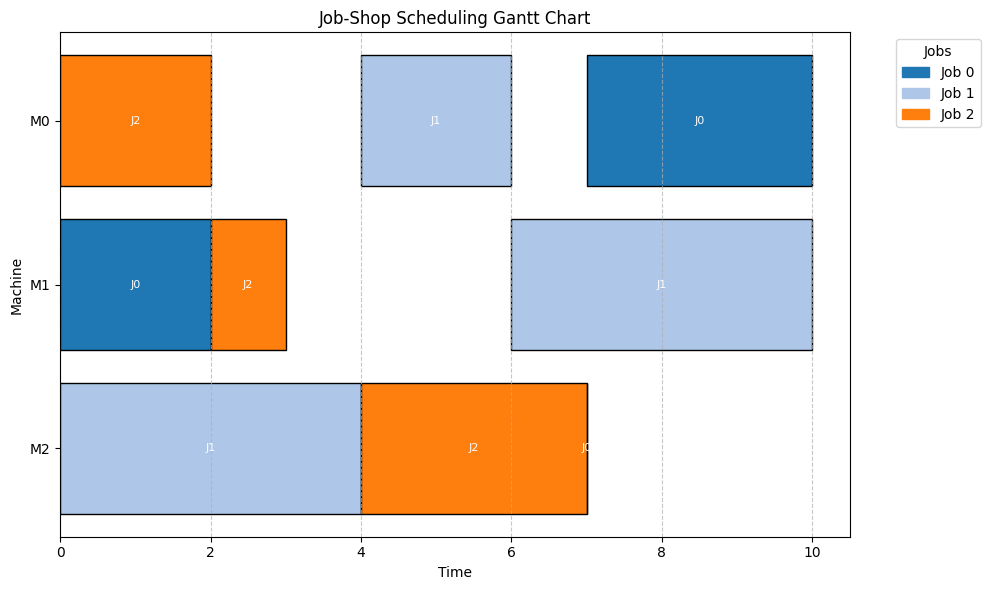

In [190]:
plot_solution(best_solution, data)